In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
import optuna
from sklearn.model_selection import cross_validate

# STATISTICS
from statsmodels.graphics.gofplots import qqplot


# turn of warnings
import warnings
warnings.filterwarnings('ignore')

In [65]:
df = pd.read_csv('data/train.csv', index_col=0)

df_test = pd.read_csv("data/test.csv", index_col=0)


In [45]:
# create a function and show results for missing values, unique values, and data types

def data_info(df):
    data = pd.DataFrame()
    data['Missing Values'] = df.isnull().sum()
    data['Unique Values'] = df.nunique()
    data['Data Type'] = df.dtypes
    return data

data_info(df)

,Missing Values,Unique Values,Data Type
Gender,0,2,object
Age,0,1703,float64
Height,0,1833,float64
Weight,0,1979,float64
family_history_with_overweight,0,2,object
FAVC,0,2,object
FCVC,0,934,float64
NCP,0,689,float64
CAEC,0,4,object
SMOKE,0,2,object


In [46]:
# create BMI column
df['BMI'] = df['Weight'] / ((df['Height']/100)**2)

In [79]:
from sklearn.base import BaseEstimator, TransformerMixin

class BMICalculator(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X['BMI'] = X['Weight'] / ((X['Height']/100)**2)
        return X


In [47]:
X_num = df.select_dtypes(include='number')
X_cat = df.select_dtypes(exclude='number')

X_cat

,Gender,family_history_with_overweight,FAVC,CAEC,SMOKE,SCC,CALC,MTRANS
id,,,,,,,,
0,Male,yes,yes,Sometimes,no,no,Sometimes,Public_Transportation
1,Female,yes,yes,Frequently,no,no,no,Automobile
2,Female,yes,yes,Sometimes,no,no,no,Public_Transportation
3,Female,yes,yes,Sometimes,no,no,Sometimes,Public_Transportation
4,Male,yes,yes,Sometimes,no,no,Sometimes,Public_Transportation
...,...,...,...,...,...,...,...,...
20753,Male,yes,yes,Sometimes,no,no,Sometimes,Public_Transportation
20754,Male,no,yes,Frequently,no,no,Sometimes,Public_Transportation
20755,Male,yes,yes,Sometimes,no,no,no,Public_Transportation


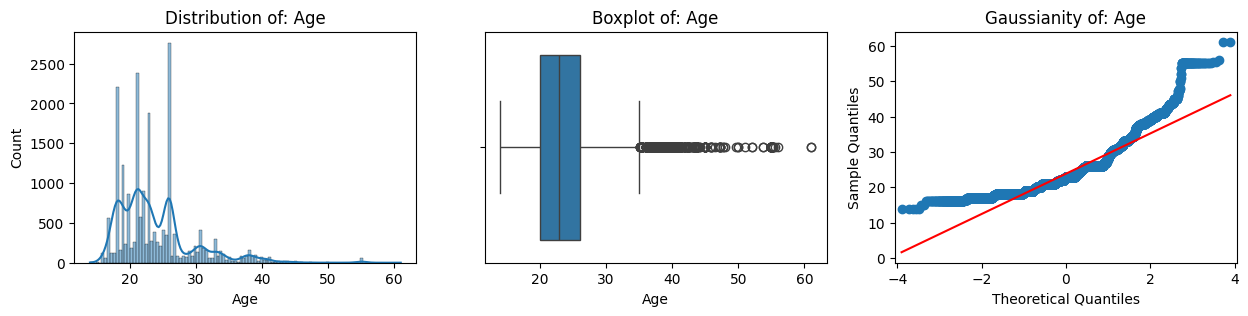

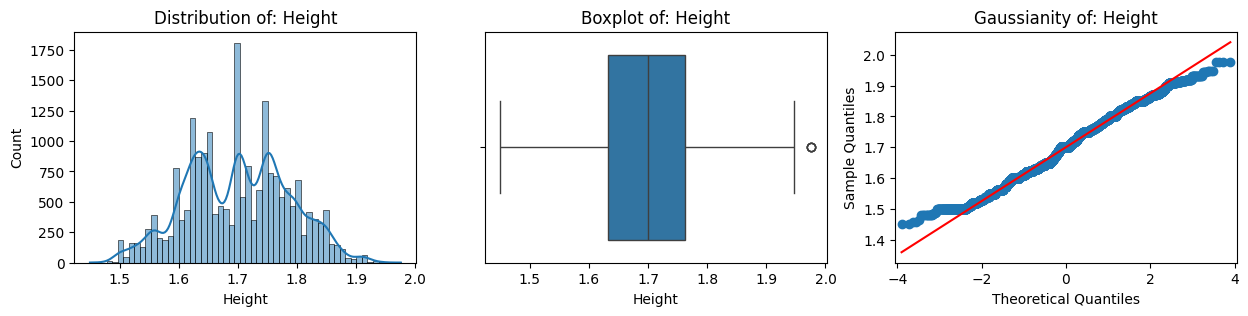

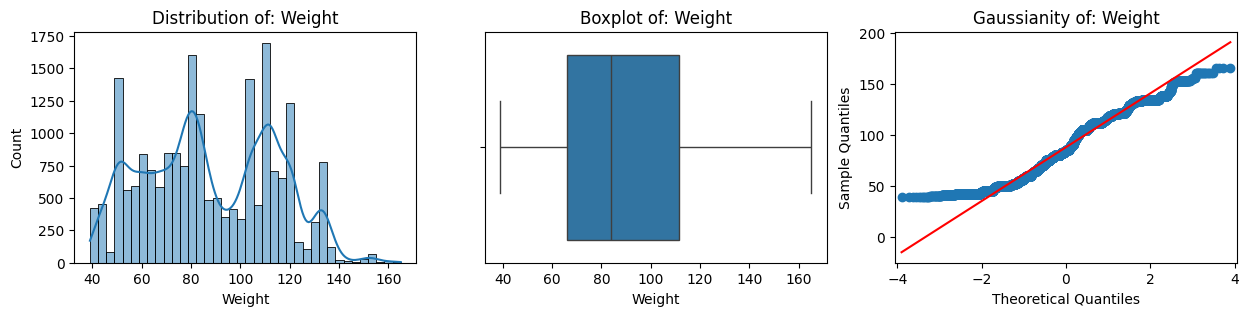

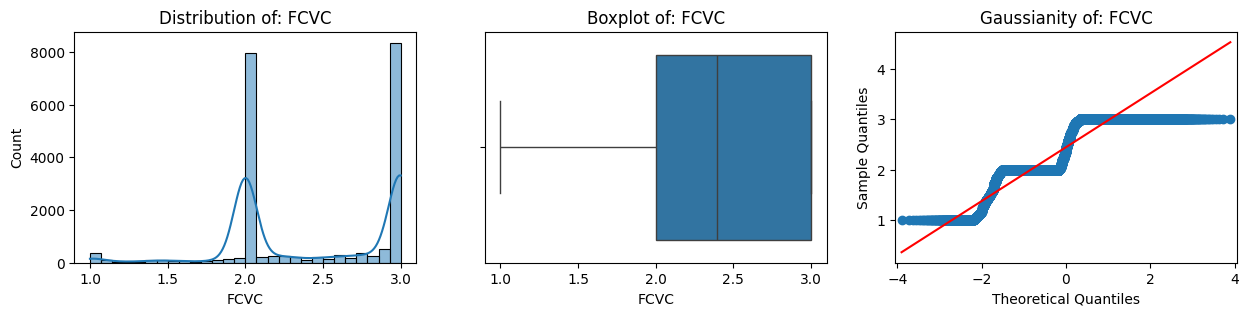

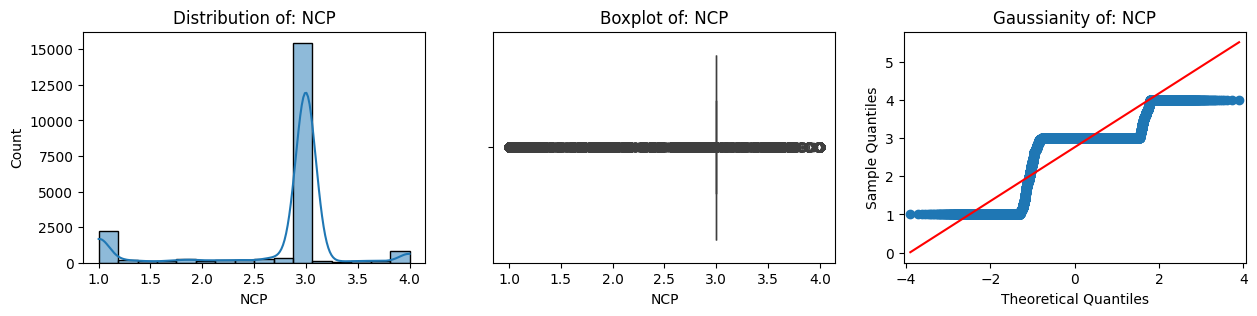

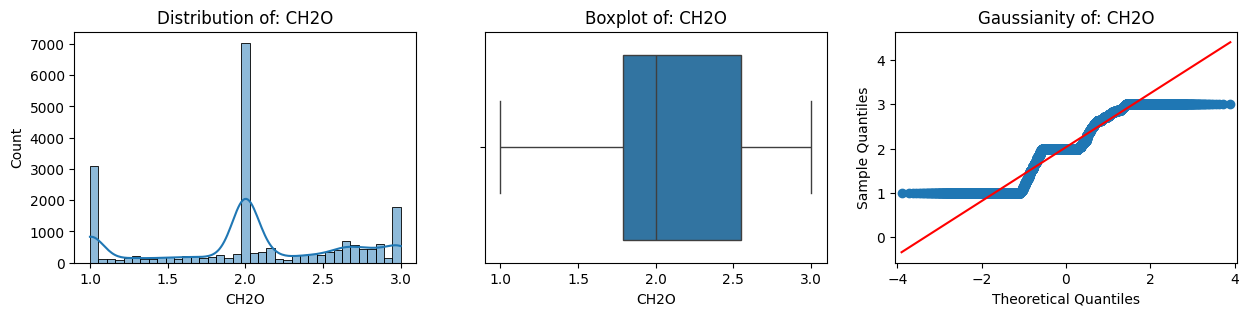

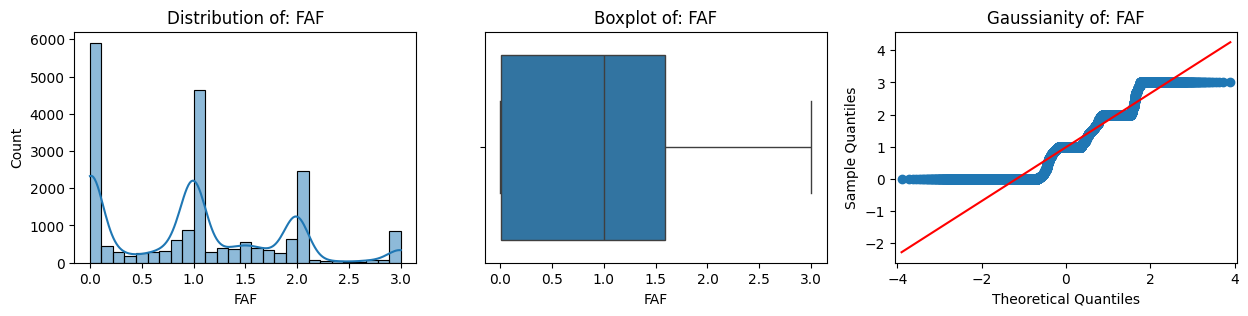

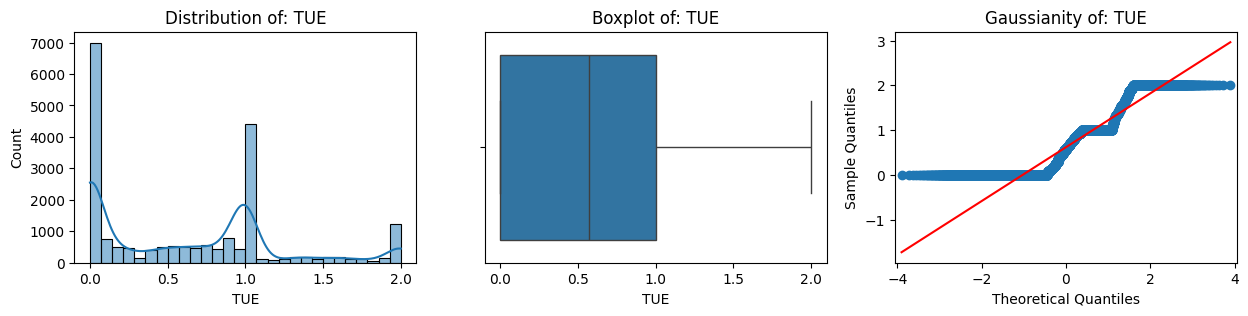

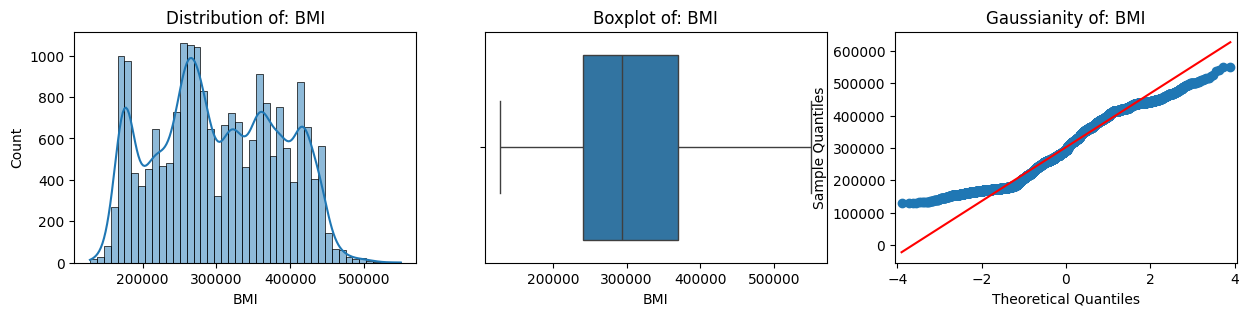

In [48]:
for numerical_feature in X_num.columns:

    # create three subplots per numerical feature
    fig, ax = plt.subplots(1, 3, figsize=(15, 3))

    # Histogram to get an overview of the distribution of each numerical_feature
    ax[0].set_title(f"Distribution of: {numerical_feature}")
    sns.histplot(data = X_num, x = numerical_feature, kde=True, ax = ax[0])

    # Boxplot to detect outliers
    ax[1].set_title(f"Boxplot of: {numerical_feature}")
    sns.boxplot(data = X_num, x = numerical_feature, ax=ax[1])

    # Analyzing whether a feature is normally distributed or not
    ax[2].set_title(f"Gaussianity of: {numerical_feature}")
    qqplot(X_num[numerical_feature],line='s',ax=ax[2]);


In [49]:
# Define the numerical columns in your dataframe
numerical_columns = X_num.columns

# Create a dictionary to store the scalers for each numerical column
scalers = {}

# Apply the appropriate scaler to each numerical column
for column in numerical_columns:
    if X_num[column].skew() > 1 or X_num[column].skew() < -1:
        scaler = RobustScaler()
    elif X_num[column].min() >= 0 and X_num[column].max() <= 1:
        scaler = MinMaxScaler()
    else:
        scaler = StandardScaler()
    X_num[column] = scaler.fit_transform(X_num[column].values.reshape(-1, 1))
    scalers[column] = scaler

# Print the scalers for each numerical column
for column, scaler in scalers.items():
    print(f"Scaler for {column}: {scaler}")


Scaler for Age: RobustScaler()
Scaler for Height: StandardScaler()
Scaler for Weight: StandardScaler()
Scaler for FCVC: StandardScaler()
Scaler for NCP: RobustScaler()
Scaler for CH2O: StandardScaler()
Scaler for FAF: StandardScaler()
Scaler for TUE: StandardScaler()
Scaler for BMI: StandardScaler()


In [50]:
# grab the names of the features where scalers values is standard scaler
standard_scaler_features = [feature for feature, scaler in scalers.items() if isinstance(scaler, StandardScaler)]
standard_scaler_features

# grab the names of the features where scalers values is robust scaler
robust_scaler_features = [feature for feature, scaler in scalers.items() if isinstance(scaler, RobustScaler)]
robust_scaler_features

['Age', 'NCP']

In [53]:
# investigate categorical features
X_cat.columns

Index(['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE',
       'SCC', 'CALC', 'MTRANS'],
      dtype='object')

In [55]:
X_cat.nunique()

Gender                            2
family_history_with_overweight    2
FAVC                              2
CAEC                              4
SMOKE                             2
SCC                               2
CALC                              3
MTRANS                            5
dtype: int64

In [88]:
ohe_features = list(X_cat.columns)
ohe_features

['Gender',
 'family_history_with_overweight',
 'FAVC',
 'CAEC',
 'SMOKE',
 'SCC',
 'CALC',
 'MTRANS']

In [127]:
preprocessor = ColumnTransformer([
    ('numerical_robust', RobustScaler(), robust_scaler_features),
    ('numerical_standard', StandardScaler(), numerical_columns),
    ('categorical', OneHotEncoder(handle_unknown='ignore'), ohe_features)
])

pipeline = Pipeline([
    ('bmi_calculator', BMICalculator()),
    ('preprocessor', preprocessor),
    ('model', XGBClassifier())
])

pipeline


Pipeline(steps=[('bmi_calculator', BMICalculator()),
                ('preprocessor',
                 ColumnTransformer(transformers=[('numerical_robust',
                                                  RobustScaler(),
                                                  ['Age', 'NCP']),
                                                 ('numerical_standard',
                                                  StandardScaler(),
                                                  Index(['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE', 'BMI'], dtype='object')),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Gender',
                                                   'family_his...
                               gamma=None, gpu_id=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=None,
                               max_leaves=None, min_child_weight=None,
                               missing=nan, monotone_constraints=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, predictor=None,
                               random_state=None, reg_alpha=None,
                               reg_lambda=None, ...))])

In [89]:
print(robust_scaler_features)
print(standard_scaler_features)
print(ohe_features)

['Age', 'NCP']
['Height', 'Weight', 'FCVC', 'CH2O', 'FAF', 'TUE', 'BMI']
['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']


In [123]:
# Encode the string class labels into integer labels
def objective(trial):

    max_depth = trial.suggest_int('max_depth', 4, 10)
    n_estimators = trial.suggest_int('n_estimators', 500, 2000)
    gamma = trial.suggest_float('gamma', 0, 1)
    reg_alpha = trial.suggest_float('reg_alpha', 0, 1)
    reg_lambda = trial.suggest_float('reg_lambda', 0, 1)
    min_child_weight = trial.suggest_int('min_child_weight', 0, 10)
    subsample = trial.suggest_float('subsample', 0, 1)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0, 1)
    learning_rate = trial.suggest_float('learning_rate', 0, 1)

    params = {'n_estimators': n_estimators,
              'learning_rate': learning_rate,
              'gamma': gamma,
              'reg_alpha': reg_alpha,
              'reg_lambda': reg_lambda,
              'max_depth': max_depth,
              'min_child_weight': min_child_weight,
              'subsample': subsample,
              'colsample_bytree': colsample_bytree,
              'eval_metric':'mlogloss'}

    preprocessor = ColumnTransformer([
        ('numerical_standard', StandardScaler(), numerical_columns),
        ('numerical_robust', RobustScaler(), robust_scaler_features),
        ('categorical', OneHotEncoder(handle_unknown='ignore'), ohe_features)
    ])

    clf = XGBClassifier(**params)

    # use pipeline to preprocess the data and train the model
    pipeline = Pipeline([
        ('bmi_calculator', BMICalculator()),
        ('preprocessor', preprocessor),
        ('model', clf)
    ])

    # use cross validation to evaluate the model
    cv_results = cross_validate(pipeline, X, y, cv=5, scoring='accuracy')

    validation_score = np.mean(cv_results['test_score'])

    return validation_score


In [91]:
%%time

X = df.drop('NObeyesdad', axis=1)
y = df['NObeyesdad']

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50, timeout=600)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-02-12 15:51:21,182] A new study created in memory with name: no-name-b1dea481-9748-4f41-b36d-8d69970d3693


Training the model with 16 features


[I 2024-02-12 15:54:37,901] Trial 0 finished with value: 0.9021583465970778 and parameters: {'max_depth': 7, 'n_estimators': 1055, 'gamma': 0.4235940008721125, 'reg_alpha': 0.9593338879351756, 'reg_lambda': 0.308139489129852, 'min_child_weight': 7, 'subsample': 0.9798248427786931, 'colsample_bytree': 0.523062195591141, 'learning_rate': 0.7006152869641699}. Best is trial 0 with value: 0.9021583465970778.


Training the model with 16 features


[I 2024-02-12 15:55:48,652] Trial 1 finished with value: 0.8817325745960882 and parameters: {'max_depth': 5, 'n_estimators': 1300, 'gamma': 0.48046802748574646, 'reg_alpha': 0.4905968863708099, 'reg_lambda': 0.36717741504572265, 'min_child_weight': 3, 'subsample': 0.22618459975013083, 'colsample_bytree': 0.14413574162675336, 'learning_rate': 0.8104551264930522}. Best is trial 0 with value: 0.9021583465970778.


Training the model with 16 features


[I 2024-02-12 15:58:13,924] Trial 2 finished with value: 0.8960402094534409 and parameters: {'max_depth': 5, 'n_estimators': 792, 'gamma': 0.21168599301198543, 'reg_alpha': 0.10048391230381948, 'reg_lambda': 0.3716967536872112, 'min_child_weight': 3, 'subsample': 0.7019377380846993, 'colsample_bytree': 0.8603350273018636, 'learning_rate': 0.7344744614734259}. Best is trial 0 with value: 0.9021583465970778.


Training the model with 16 features


[I 2024-02-12 16:00:05,065] Trial 3 finished with value: 0.8991234208253089 and parameters: {'max_depth': 8, 'n_estimators': 638, 'gamma': 0.11172373742066233, 'reg_alpha': 0.6416028628352541, 'reg_lambda': 0.1178582273982145, 'min_child_weight': 3, 'subsample': 0.5958973169399542, 'colsample_bytree': 0.486696229938565, 'learning_rate': 0.6581759831099585}. Best is trial 0 with value: 0.9021583465970778.


Training the model with 16 features


[I 2024-02-12 16:01:35,781] Trial 4 finished with value: 0.9040372610263144 and parameters: {'max_depth': 5, 'n_estimators': 585, 'gamma': 0.6771773198911187, 'reg_alpha': 0.018306900924833336, 'reg_lambda': 0.614474814610889, 'min_child_weight': 1, 'subsample': 0.594216602414252, 'colsample_bytree': 0.4429193232017019, 'learning_rate': 0.36640915057387347}. Best is trial 4 with value: 0.9040372610263144.


Number of finished trials:  5
Best trial:
  Value: 0.9040372610263144
  Params: 
    max_depth: 5
    n_estimators: 585
    gamma: 0.6771773198911187
    reg_alpha: 0.018306900924833336
    reg_lambda: 0.614474814610889
    min_child_weight: 1
    subsample: 0.594216602414252
    colsample_bytree: 0.4429193232017019
    learning_rate: 0.36640915057387347
CPU times: user 1h 4min 36s, sys: 12min 37s, total: 1h 17min 14s
Wall time: 10min 14s


In [92]:
best_params = study.best_trial.params
best_params['eval_metric'] = 'mlogloss'
best_params['use_label_encoder'] = False

In [93]:
best_params

{'max_depth': 5,
 'n_estimators': 585,
 'gamma': 0.6771773198911187,
 'reg_alpha': 0.018306900924833336,
 'reg_lambda': 0.614474814610889,
 'min_child_weight': 1,
 'subsample': 0.594216602414252,
 'colsample_bytree': 0.4429193232017019,
 'learning_rate': 0.36640915057387347,
 'eval_metric': 'mlogloss',
 'use_label_encoder': False}

In [114]:
X = df.drop('NObeyesdad', axis=1)
y = df['NObeyesdad']

#apply label encoder to the target variable
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

#check unique values names for categorical features
print(label_encoder.classes_)

['Insufficient_Weight' 'Normal_Weight' 'Obesity_Type_I' 'Obesity_Type_II'
 'Obesity_Type_III' 'Overweight_Level_I' 'Overweight_Level_II']


In [131]:
clf = XGBClassifier(**best_params)

pipeline = Pipeline([
    ('bmi_calculator', BMICalculator()),
    ('preprocessor', preprocessor),
    ('model', clf)
])

# fit the model
pipeline.fit(X, y)

# predict the target variable
y_pred = pipeline.predict(X)

# calculate the accuracy
accuracy = np.mean(y == y_pred)
print(f"Accuracy: {accuracy:.2%}")


Accuracy: 99.25%


In [134]:
# apply the pipeline to the test data
X_test = df_test
y_pred = pipeline.predict(X_test)

In [135]:
y_pred

array([3, 5, 4, ..., 0, 1, 3])

In [137]:
y_pred = label_encoder.inverse_transform(y_pred)
y_pred

array(['Obesity_Type_II', 'Overweight_Level_I', 'Obesity_Type_III', ...,
       'Insufficient_Weight', 'Normal_Weight', 'Obesity_Type_II'],
      dtype=object)

In [142]:
df_submission = pd.DataFrame(y_pred, index=X_test.index, columns=['NObeyesdad'])
df_submission.to_csv('data/submission9.csv')
df_submission

,NObeyesdad
id,
20758,Obesity_Type_II
20759,Overweight_Level_I
20760,Obesity_Type_III
20761,Obesity_Type_I
20762,Obesity_Type_III
...,...
34593,Overweight_Level_II
34594,Normal_Weight
34595,Insufficient_Weight
